# Training regular Convolutional Neural Network (CNN) based classifier

This is a short tutorial explaining how to convert simulation outputs into images and use them to train CNN model.

Content of this tutorial:
1. Create images from simulation outputs
2. Load and preprocess images
3. Implement CNN
4. Train and evaluate the model

All the required functions are contained in BaSe module. So should first load BaSe:

In [4]:
%run -i ../BaSe/Preprocess.py
%run -i ../BaSe/Model.py

Now, we define paths to directories in which simulation outputs, images and trained model will be stored:

In [20]:
path_to_sim = '/Users/ulas/Projects/balancing_selection/Data/SimOuts/' # Directory where simulation outputs are stored
path_to_image = '/Users/ulas/Projects/balancing_selection/Data/Images/' # Directory where images will be stored
path_to_save = '/Users/ulas/Projects/balancing_selection/Data/Model/'   # Directory where trained model and data will be stored

### 1. Create images
In order to train CNN, we should create images from simulations. In this tutorial, we assume that simulations are performed and ready. To learn how to run simulations, you can view `../Simulations/README.md`. 

__Importantly__, this function assumes that all the simulation outputs are in the same folder with the specific file names. Given the output folder in `../Simulations/Params.txt`, the scripts in `../Simulations` produce outputs with a specific naming pattern. However, if you modify the names of simulation output files, this function may not work as expected.

To convert simulations into images, we can use `sim_to_image(path_to_sim, path_to_image, clss, SIM_FROM, SIM_TO, NCHROMS, N, N_NE, img_dim, sort, method)` function. It accepts following arguments:

* __path_to_sim__: Path to directory where the simulation files exist
* __path_to_image__: Path to directory where the images will be stored
* __clss__: A tuple of target simulation classes:
    * __NE__: Neutral
    * __IS__: Incomplete sweep
    * __OD__: Overdominance
    * __FD__: Negative frequency dependent selection
* __SIM_FROM__: Simulation number to include -starting from
* __SIM_TO__: Simulation number to include -until
* __N__: Length of the simulated sequence(bp) for selection scenarios
* __N_NE__: Length of simulated sequence(bp) for neutral scenario
* __NCHROMS__: Number of samples(haploid individuals, or chromosoms)
* __img_dim__: Image dimensions (nrow, ncol)
* __sort__: Sorting algorithm. either:
    * __gen_sim__: sorting based on genetic similarity
    * __freq__: sorting based on frequency
* __method__: sorting method. either:
    * __t__: together. sorting whole individuals together
    * __s__: seperate. sorting two haplotype groups seperately.
    
Here, we can choose one of the different sorting algoritms and methods. This function also allows to resize image for given dimensions.

In [1]:
sim_to_image(path_to_sim, path_to_image, clss=("NE", "IS", "OD", "FD"), SIM_FROM=1, SIM_TO=3000, NCHROMS=198, 
             N=50000, N_NE=500000, img_dim=(128,128), sort="freq", method="t")

This will create image for each simulated sequence seperately.

### 2. Load and preprocess images

Images can be loaded and preprocessed by `Images` class. Required key arguments for initiation of the object:
* __test__: Test number to be performed:
    * __1__: Neutrality vs Selection(IS+OD+FD)
    * __2__: Incomplete sweep vs Balancing selection(OD+FD)
    * __3__: Overdominance vs Negative frequency dependent selection
* __selection_category__: Specifies the time of onset of selection for selection scenarios. Possible bins:
    * __recent__: Includes selection scenarios ranging from 20k to 26k years old.
    * __medium__: Includes selection scenarios ranging from 27k to 33k years old.
    * __old__: Includes selection scenarios ranging from 34k to 40k years old.
* __N__: Number of samples that will be included per class
* __img_dim__: Dimensions of the images (nrow, ncol)

In [21]:
test = 1                         # We will perform test 1: neutrality vs selection
selection_category = "recent"    # Recent selection category
image_size = (128,128)          

images = Images(test=1, selection_category="recent", N=210, img_dim=image_size)

Now, to load and preprocess images, we can use `load_images()` function. It accepts following key arguments:
* __path_to_image__: Path to directory where the images are stored
* __val_size__: Float between 0 and 1 specifying proportion of data that will used for validation
* __toshuggle__: If True, shuffles the data before splitting

In [22]:
X_train, X_val, y_train, y_val = images.load_images(path_to_image, val_size=0.2, toshuffle=True, 
                                                    random_state=2, verbose=1)

Times of onset of selection for selection scenarios: [20, 21, 22, 23, 24, 25, 26]
Total sample sizes:
Neutral: 210
Selection: 210 = 70(IS) + 70(FD) + 70(OD) 

Sample sizes for each selection start time:
FD for 20 k years old selection:  10
FD for 21 k years old selection:  10
FD for 22 k years old selection:  10
FD for 23 k years old selection:  10
FD for 24 k years old selection:  10
FD for 25 k years old selection:  10
FD for 26 k years old selection:  10
IS for 20 k years old selection:  10
IS for 21 k years old selection:  10
IS for 22 k years old selection:  10
IS for 23 k years old selection:  10
IS for 24 k years old selection:  10
IS for 25 k years old selection:  10
IS for 26 k years old selection:  10
OD for 20 k years old selection:  10
OD for 21 k years old selection:  10
OD for 22 k years old selection:  10
OD for 23 k years old selection:  10
OD for 24 k years old selection:  10
OD for 25 k years old selection:  10
OD for 26 k years old selection:  10


We can also save these files using `save()` function from numpy module:

In [23]:
import numpy as np

np.save("{}CNN_X_train_{}_{}".format(path_to_save, selection_category, test), X_train, allow_pickle=False)
np.save("{}CNN_y_train_{}_{}".format(path_to_save, selection_category, test), y_train, allow_pickle=False)
np.save("{}CNN_X_val_{}_{}".format(path_to_save, selection_category, test), X_val, allow_pickle=False)
np.save("{}CNN_y_val_{}_{}".format(path_to_save, selection_category, test), y_val, allow_pickle=False)

### 3. Implement CNN

Having training and validation data, we can build our model. BaSe module includes pre-compiled models whose parameters are optimized for each test separetly. Therefore, you can either load these models or implement a custum one.

#### a. Load model
Pre-compiled and optimized models can be loaded using `LoadCNN(test)` by specifiying the test number and image dimensions:

In [8]:
mymodel = LoadCNN(test=1, img_dim=image_size)

#### b. Implement custom model
Alternatively, you can implement a custom model by using `MakeCNN()`:

In [9]:
# mymodel = MakeCNN(input_shape=(128,128), lr=0.0005, lr_dec=0.00001, filters=[32,32,32], kernel_size=3, 
#                   pooling_size=2, l2_regularizer=0.005, units_fc=[128], batch_norm = True,
#                  dropout_conv=0.5, dropout_fc=0.5, initializer='uniform', strides=(1,1), padding='same')

The above example code will create a CNN model with 3 conv layers (each having 32 filters) and one fully connected layer with 128 units. Still, if you want to use a different model that cannot be created using `MakeCNN` (e.g. different optimizer, or more complex structure), you can use `mymodel = CustomModel(model)`. Here, input can be any compiled keras model.

Nevertheless, we will use optimized and pre-compiled models in this tutorial. After loading the model, you can use `summary()` function to obtain an overview of the model:

In [10]:
mymodel.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 128, 128, 1)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 32)      320       
_________________________________________________________________
batch_normalization_1 (Batch (None, 128, 128, 32)      128       
_________________________________________________________________
activation_1 (Activation)    (None, 128, 128, 32)      0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 64, 32)        9248      
_________________________________________________________________
batch_normalization_2 (Batch (None, 64, 64, 32)        128       
__________

### 4. Train and evaluate the model

Having both data and model, we are ready to train the model. To do so, we can use `fit_model()` function:

In [11]:
mymodel.fit_model(X_train, y_train, batch_size=64, epoch=10, aug=True, validation_data=(X_val, y_val), verbose=2)

Epoch 1/10
 - 21s - loss: 19.7166 - acc: 0.4854 - val_loss: 19.4908 - val_acc: 0.4091
Epoch 2/10
 - 22s - loss: 19.4016 - acc: 0.5359 - val_loss: 18.8925 - val_acc: 0.4091
Epoch 3/10
 - 25s - loss: 19.2202 - acc: 0.5026 - val_loss: 18.4096 - val_acc: 0.4773
Epoch 4/10
 - 25s - loss: 19.4467 - acc: 0.4654 - val_loss: 18.4143 - val_acc: 0.4545
Epoch 5/10
 - 24s - loss: 19.0032 - acc: 0.4948 - val_loss: 18.6860 - val_acc: 0.4091
Epoch 6/10
 - 25s - loss: 19.2213 - acc: 0.4974 - val_loss: 18.7688 - val_acc: 0.3864
Epoch 7/10
 - 24s - loss: 18.7878 - acc: 0.5360 - val_loss: 18.5362 - val_acc: 0.4318
Epoch 8/10
 - 27s - loss: 18.7130 - acc: 0.5478 - val_loss: 18.3631 - val_acc: 0.5227
Epoch 9/10
 - 25s - loss: 18.9354 - acc: 0.4839 - val_loss: 18.3179 - val_acc: 0.5227
Epoch 10/10
 - 26s - loss: 18.8081 - acc: 0.5307 - val_loss: 18.3868 - val_acc: 0.4773


If `aug=True`, perform augmentation by randomly flipping images horizontally. Having the train model, we can access training history:

In [9]:
# print(mymodel.train_loss)  # Prints training loss
# print(mymodel.train_acc)   # Prints training accuracy
# print(mymodel.val_loss)    # Prints validation loss
# print(mymodel.val_acc)     # Prints validation accuracy

Using `vis_acc_loss()` we can plot the change in both validation and training loss and accuracy during the training.

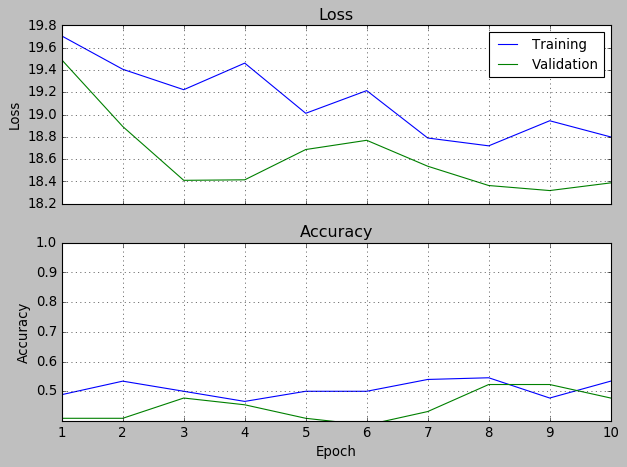

In [17]:
mymodel.vis_acc_loss()

We can also plot the confusion matrix using validation data:

44/44 [==============================] - 1s 25ms/step


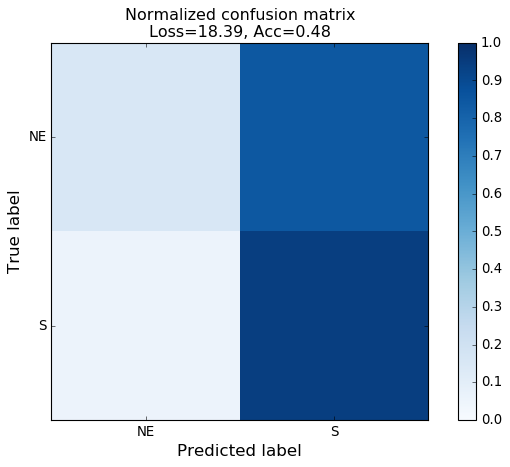

In [18]:
mymodel.vis_cm(X_val, y_val, images.classes)

Lastly, in order to use this trained model in the testing on real data, we should save it:

In [12]:
mymodel.save_model("{}CNN_model_{}_{}.h5".format(path_to_save, selection_category, test))